In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2023-04-12 13:26:01.785682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 13:26:01.979943: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 13:26:01.981876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 13:26:02.825694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TF version: 2.12.0
Hub version: 0.13.0
GPU is NOT AVAILABLE


2023-04-12 13:26:04.191188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 13:26:04.192128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
ATTR_PATH = "/home/ali/projects/photo_collection/celebface-archive/list_attr_celeba.csv" # contains the image attributes (Male, Smiling, Young, ...)
PARTITION_PATH = "/home/ali/projects/photo_collection/celebface-archive/list_eval_partition.csv" # contains the recommended partitioning of images into training, validation and testing sets.# contains the recommended partitioning of images into training, validation and testing sets.
IMAGES_PATH = "/home/ali/projects/photo_collection/celebface-archive/img_align_celeba/img_align_celeba/" # contains the .jpg images
BATCH_SIZE = 128  # try a smaller batch size if you have limited computational resources
MODEL_HANDLE = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"  # we use this pretrained model to obtain a feature vector from each image
IMAGE_SIZE = (224, 224)  # input size required by our pretrained model

In [3]:
#Merging attributes and suggested partitioning on "image_id"

df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [5]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [6]:
def load_and_preprocess_from_path_label(path, male, smiling, young):
    images = load_and_preprocess_image(path)
    return images, male, smiling, young

In [11]:
def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices((
        [IMAGES_PATH + image_id for image_id in df["image_id"]],
        list(df["Male"].replace(-1, 0)),
        list(df["Smiling"].replace(-1, 0)),
        list(df["Young"].replace(-1, 0))
    ))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [12]:
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [13]:
# train_df = df.loc[df["partition"] == 0]
# # if you're in a rush, add: train_df = train_df.sample(n=5000)
# train_ds = build_dataset_from_df(train_df)
#
# val_df = df.loc[df["partition"] == 1]
# # if you're in a rush, add: val_df = val_df.sample(n=1000)
# val_ds = build_dataset_from_df(val_df)

In [14]:
train_df = df.loc[df["partition"] == 0]
train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1]
val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df)

In [15]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-12 13:27:15.150770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_2}}]]
2023-04-12 13:27:15.151443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_3}}]]
2023-04-12 13:27:15.747462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.
2023-04-12 13:27:15.838188: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.


[(array([[[[ 45.       ,  59.       ,  44.       ],
           [ 45.       ,  59.       ,  44.       ],
           [ 45.973213 ,  59.973213 ,  44.973213 ],
           ...,
           [ 34.026794 ,  48.026794 ,  33.026794 ],
           [ 35.       ,  49.       ,  34.       ],
           [ 35.       ,  49.       ,  34.       ]],
  
          [[ 47.879463 ,  61.879463 ,  46.879463 ],
           [ 47.879463 ,  61.879463 ,  46.879463 ],
           [ 48.38562  ,  62.38562  ,  47.38562  ],
           ...,
           [ 34.9609   ,  48.9609   ,  33.9609   ],
           [ 35.       ,  49.       ,  34.       ],
           [ 35.       ,  49.       ,  34.       ]],
  
          [[ 48.933037 ,  62.933037 ,  47.933037 ],
           [ 48.933037 ,  62.933037 ,  47.933037 ],
           [ 49.419643 ,  63.419643 ,  48.419643 ],
           ...,
           [ 35.454018 ,  49.454018 ,  34.454018 ],
           [ 35.       ,  49.       ,  34.       ],
           [ 35.       ,  49.       ,  34.       ]],
  
    

In [16]:
for image, male, smiling, young in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label gender: ", male.shape)
    print("Label smiling: ", smiling.shape)
    print("Label young: ", young.shape)

2023-04-12 13:27:22.165716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]
2023-04-12 13:27:22.166318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_3}}]]


Image shape:  (128, 224, 224, 3)
Label gender:  (128,)
Label smiling:  (128,)
Label young:  (128,)


2023-04-12 13:27:22.504628: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.


2023-04-12 13:27:25.170893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_3}}]]
2023-04-12 13:27:25.171432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5000]
	 [[{{node Placeholder/_0}}]]
2023-04-12 13:27:25.648707: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.


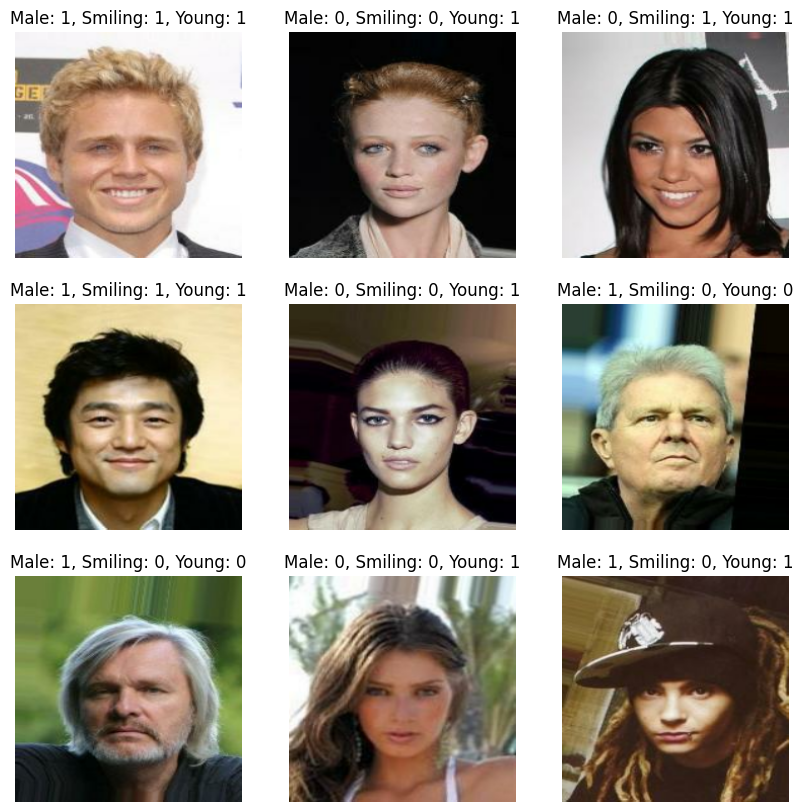

In [17]:
image, male, smiling, young = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = f"Male: {male[i].numpy()}, Smiling: {smiling[i].numpy()}, Young: {young[i].numpy()}"
    plt.title(s)
    plt.axis("off")

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, male, smiling, young:
                        (preprocessing_model(images), (male, smiling, young)))

val_ds = val_ds.map(lambda images, male, smiling, young:
                    (normalization_layer(images), (male, smiling, young)))

In [19]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-12 13:27:51.247952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_2}}]]
2023-04-12 13:27:51.248827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_2}}]]
2023-04-12 13:27:51.731436: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.


[(array([[[[5.52941203e-01, 4.90196109e-01, 6.66666687e-01],
           [5.55654824e-01, 4.92909700e-01, 6.69380307e-01],
           [5.56862772e-01, 4.94117677e-01, 6.70588255e-01],
           ...,
           [5.92156887e-01, 5.31320035e-01, 7.03974128e-01],
           [5.92156887e-01, 5.29411793e-01, 7.05882370e-01],
           [5.92156887e-01, 5.29411793e-01, 7.05882370e-01]],
  
          [[5.52941203e-01, 4.90196109e-01, 6.66666687e-01],
           [5.55654824e-01, 4.92909700e-01, 6.69380307e-01],
           [5.56862772e-01, 4.94117677e-01, 6.70588255e-01],
           ...,
           [5.92156887e-01, 5.31320035e-01, 7.03974128e-01],
           [5.92156887e-01, 5.29411793e-01, 7.05882370e-01],
           [5.92156887e-01, 5.29411793e-01, 7.05882370e-01]],
  
          [[5.52941203e-01, 4.90196109e-01, 6.66666687e-01],
           [5.55654824e-01, 4.92909700e-01, 6.69380307e-01],
           [5.56862772e-01, 4.94117677e-01, 6.70588255e-01],
           ...,
           [5.92156887e-01, 5

In [29]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

out_male = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='male')(x)
out_smiling = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='smiling')(x)
out_young = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='young')(x)

model = tf.keras.Model( inputs = input, outputs = [out_male, out_smiling, out_young])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [30]:
model.compile(
    loss = {
        "male": tf.keras.losses.BinaryCrossentropy(),
        "smiling": tf.keras.losses.BinaryCrossentropy(),
        "young": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "male": 'accuracy',
        "smiling": 'accuracy',
        "young": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [31]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3


2023-04-10 12:25:27.216847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_1}}]]
2023-04-10 12:25:27.217237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [5000]
	 [[{{node Placeholder/_1}}]]
2023-04-10 12:25:27.818987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/head/StatefulPartitionedCall_grad/head/St

39/39 [==============================] - ETA: 0s - loss: 1.2413 - male_loss: 0.2442 - smiling_loss: 0.5797 - young_loss: 0.4168 - male_accuracy: 0.9026 - smiling_accuracy: 0.6913 - young_accuracy: 0.8257

2023-04-10 12:28:45.432647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_2}}]]
2023-04-10 12:28:45.433930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


39/39 [==============================] - 238s 6s/step - loss: 1.2413 - male_loss: 0.2442 - smiling_loss: 0.5797 - young_loss: 0.4168 - male_accuracy: 0.9026 - smiling_accuracy: 0.6913 - young_accuracy: 0.8257 - val_loss: 0.9470 - val_male_loss: 0.1111 - val_smiling_loss: 0.4535 - val_young_loss: 0.3818 - val_male_accuracy: 0.9587 - val_smiling_accuracy: 0.8025 - val_young_accuracy: 0.8404
Epoch 2/3
39/39 [==============================] - 218s 6s/step - loss: 0.9254 - male_loss: 0.1541 - smiling_loss: 0.4551 - young_loss: 0.3156 - male_accuracy: 0.9449 - smiling_accuracy: 0.7867 - young_accuracy: 0.8726 - val_loss: 0.8683 - val_male_loss: 0.1043 - val_smiling_loss: 0.4028 - val_young_loss: 0.3606 - val_male_accuracy: 0.9621 - val_smiling_accuracy: 0.8259 - val_young_accuracy: 0.8471
Epoch 3/3
39/39 [==============================] - 210s 5s/step - loss: 0.8581 - male_loss: 0.1384 - smiling_loss: 0.4123 - young_loss: 0.3069 - male_accuracy: 0.9491 - smiling_accuracy: 0.8099 - young_accu

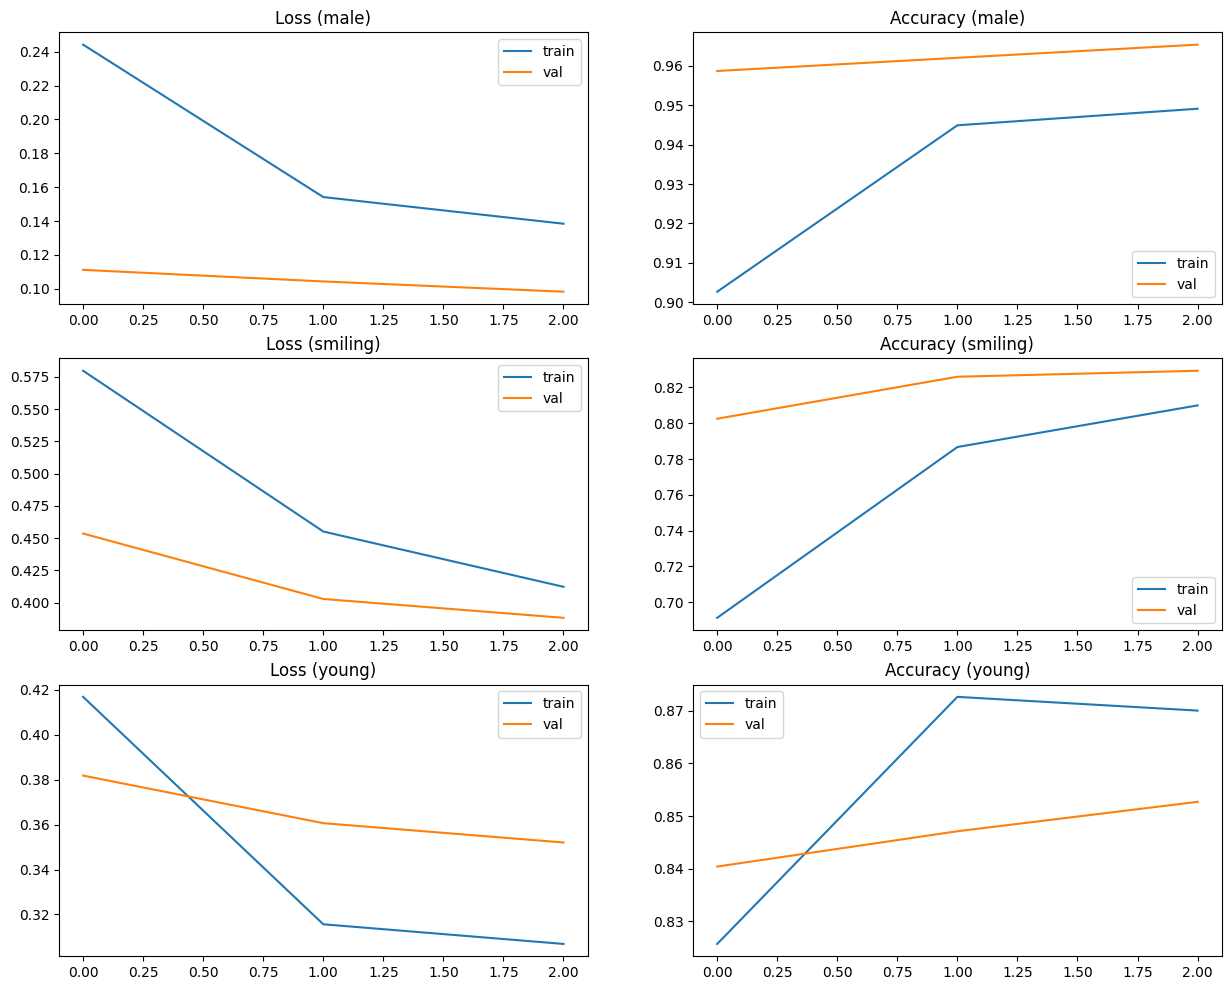

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
for i, c in enumerate(["male", "smiling", "young"]):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

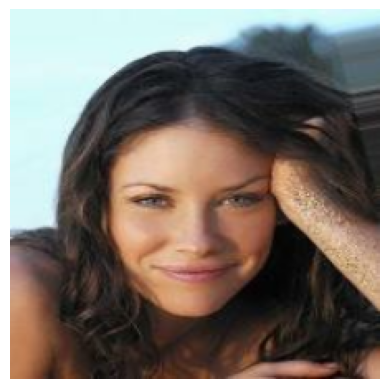

1/1 [==============================] - 0s 54ms/step
Male: actual 0, predicted 0 (0.0013)
Smiling: actual 1, predicted 1 (0.7852)
Young: actual 1, predicted 1 (0.9905)


In [37]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")